# Topics in English Quran

In [1]:
import glob
from collections import defaultdict

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.util import ngrams
from gensim import corpora, models
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
pd.set_option('max_colwidth', 400)
pd.set_option('display.max_rows', 500)

# import nltk
# nltk.download()

In [2]:
def parse_docs(docs, is_stop=True, additional_stops=None):
    # removing whitespaces, punctuations, stopwords, and stemming words
    # https://gist.github.com/sangheestyle/8691435
    intermediates = []
    processed = []
    stem_map = defaultdict(set)
    
    tokenizer = RegexpTokenizer(r'\w+')
    stop = stopwords.words('english')
    stemmer = PorterStemmer()
    
    # Remove udf stop words
    if additional_stops is not None:
        stop = stop + additional_stops 
    
    for document in docs:
        intermediate = tokenizer.tokenize(document)    
#         POS tagging
#         ntlk.pos_tag()
        if is_stop:
            intermediate = [i for i in intermediate if i not in stop]        
        intermediates.append(intermediate)
        
        # FIXME: using other stemmers also to know quality of each stemmed text
        final = []
        for i in intermediate:
            stemmed = stemmer.stem(i)
            final.append(stemmed)
            stem_map[stemmed].add(i)

        
        processed.append(final)
    
    return intermediates, processed, stem_map

def word_cloud(input_text):
    # Read the whole text.
    text = ' '.join(input_text)
    # Generate a word cloud image
    wordcloud = WordCloud().generate(text)
    # lower max_font_size
    wordcloud = WordCloud(max_font_size=60).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [3]:
sura_medina = [2, 3, 4, 5, 8, 9, 22, 24, 33, 47, 48, 49, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 98, 110]
sura_mecca_first = [96, 74, 111, 106, 108, 104, 107, 102, 105, 92,
90, 94, 93, 97, 86, 91, 80, 68, 87, 95,
103, 85, 73, 101, 99, 82, 81, 53, 84, 100,
79, 77, 78, 88, 89, 75, 83, 69, 51, 52,
56, 70, 55, 112, 109, 113, 114, 1]
sura_mecca_second = [54, 37, 71, 76, 44, 50, 20, 26, 15, 19,
38, 36, 43, 72, 67, 23, 21, 25, 17, 27, 18]
sura_mecca_third = [32, 41, 45, 16, 30, 11, 14, 12, 40, 28,
39, 29, 31, 42, 10, 34, 35, 7, 46, 6, 13]
sura_ind = [sura_mecca_first, sura_mecca_second, sura_mecca_third, sura_medina]

Basmala = 'in the name of allah, the gracious, the merciful.'

### Downloaded http://www.clearquran.com/

### Read in and decode

In [4]:
data_folder = '../data/quran-verse-by-verse-text/'

documents = [] # chapters->chapters
for chapter in range(1, 115):
    files = sorted(glob.glob(data_folder + str(chapter).zfill(3) + '*'))
    # Remove non ascii and change to lower case; not necessary with RegexpTokenizer(r'\w+')
    verses = []
    for f in files:
        with open(f, 'rb') as hf:
            text = hf.read()
            verses.append(text.decode('utf-8').encode('ascii', errors='ignore').lower().decode('utf-8'))
    documents.append(verses)

### [optional] Separate by time

In [5]:
# chapters->verses, remove Basmala
suras = range(1, 115) #sura_ind[-1]

seg_docs = [documents[ii - 1] for ii in suras]

docs = []
i_surah = []
i_verse = []
for i, surah in enumerate(seg_docs):
    for j, verse in enumerate(surah):
        docs.append(verse)
        i_surah.append(i + 1)
        i_verse.append(j + 1)

In [6]:
is_remove_basm = True
if is_remove_basm:
    for i, j in enumerate(i_verse):
        if j == 1:
            del i_verse[i]
            del i_surah[i]
            del docs[i]

In [7]:
df0 = pd.DataFrame({'text': docs, 'surah': i_surah, 'verse': i_verse})

### Parsing 

In [8]:
additional_stops = None #['god', 'lord']
tokens, processed, stem_map = parse_docs(docs, is_stop=True, additional_stops=additional_stops)


In [9]:

# making dictionary and corpus
# dictionary = corpora.Dictionary(processed)
# corpus = [dictionary.doc2bow(text) for text in processed]

# Save
#dictionary.save('/tmp/dict.dict')
#corpora.MmCorpus.serialize('/tmp/temp.mm', corpus)

### Word freq

In [10]:
df = pd.Series([jj for ii in processed for jj in ii])

In [11]:
df.value_counts()[:4]

allah    2628
lord      968
say       814
said      774
dtype: int64

In [12]:
count = 0
for ii, jj in enumerate(tokens):    
    if 'day' in jj:
        count += 1
        print(ii, docs[ii])
        if count > 2:
            break

2 master of the day of judgment.
13 among the people are those who say, we believe in allah and in the last day, but they are not believers.
53 and beware of a day when no soul will avail another in the least, nor will any intercession be accepted on its behalf, nor will any ransom be taken from it, nor will they be helped.


### get ngram

In [13]:
num_grams = 3
input_corpus = processed
ngrams_by_verse = [list(ngrams(token, num_grams)) for token in input_corpus]

In [14]:
all_ngrams = []
ind_surah = []
ind_verse = []
for i, j in enumerate(ngrams_by_verse):
    for g in j:
        ind_surah.append(i_surah[i])
        ind_verse.append(i_verse[i])
        all_ngrams.append(g)

In [15]:
dfng = pd.DataFrame({'value': all_ngrams, 'surah': ind_surah, 'verse': ind_verse})

In [16]:
dfng_j = pd.merge(dfng, df0, on=['surah', 'verse'])

In [19]:
dfng_j['value'].value_counts()[:10]

(allah, forgiv, merci)       43
(lord, marvel, deni)         32
(creat, heaven, earth)       32
(beneath, river, flow)       30
(garden, beneath, river)     26
(allah, last, day)           23
(everyth, heaven, earth)     23
(believ, allah, last)        21
(believ, good, deed)         20
(belong, everyth, heaven)    18
Name: value, dtype: int64

In [18]:
dfng_j[dfng_j['value'] == dfng_j['value'].value_counts().index[0]][:4]

,value,surah,verse,text
1848,"(allah, forgiv, merci)",2,174,"he has forbidden you carrion, and blood, and the flesh of swine, and what was dedicated to other than allah. but if anyone is compelled, without desiring or exceeding, he commits no sin. allah is forgiving and merciful."
1977,"(allah, forgiv, merci)",2,183,"should someone suspect bias or injustice on the part of a testator, and then reconciles between them, he commits no sin. allah is forgiving and merciful."
2139,"(allah, forgiv, merci)",2,193,"but if they cease, then allah is forgiving and merciful."
2265,"(allah, forgiv, merci)",2,200,"then disperse from where the people disperse, and ask allah for forgiveness. allah is most forgiving, most merciful."


## embedding and similarity 

In [214]:
import gensim.models as w2v
model = w2v.Word2Vec(sentences=processed, size=100, window=7, min_count=15, sg=0, alpha=0.22, workers=8)
# model.save('./tokens_CBOW.model')

c:\users\yuwei\dropbox\code\pve\pve\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [218]:
wv = model.wv

In [227]:
wv.most_similar("jesu", topn=10)

[('mari', 0.748776912689209),
 ('isaac', 0.6510797739028931),
 ('gave', 0.6142046451568604),
 ('son', 0.5961546897888184),
 ('recal', 0.5579920411109924),
 ('abraham', 0.5411198139190674),
 ('aaron', 0.5320774912834167),
 ('spirit', 0.5117001533508301),
 ('david', 0.4957510232925415),
 ('noah', 0.4749738574028015)]

In [178]:
from sklearn.decomposition import PCA
words = df.value_counts()[:200].index.values
X = np.array([wv[w] for w in words])

pca = PCA(n_components=2)
result = pca.fit_transform(X)


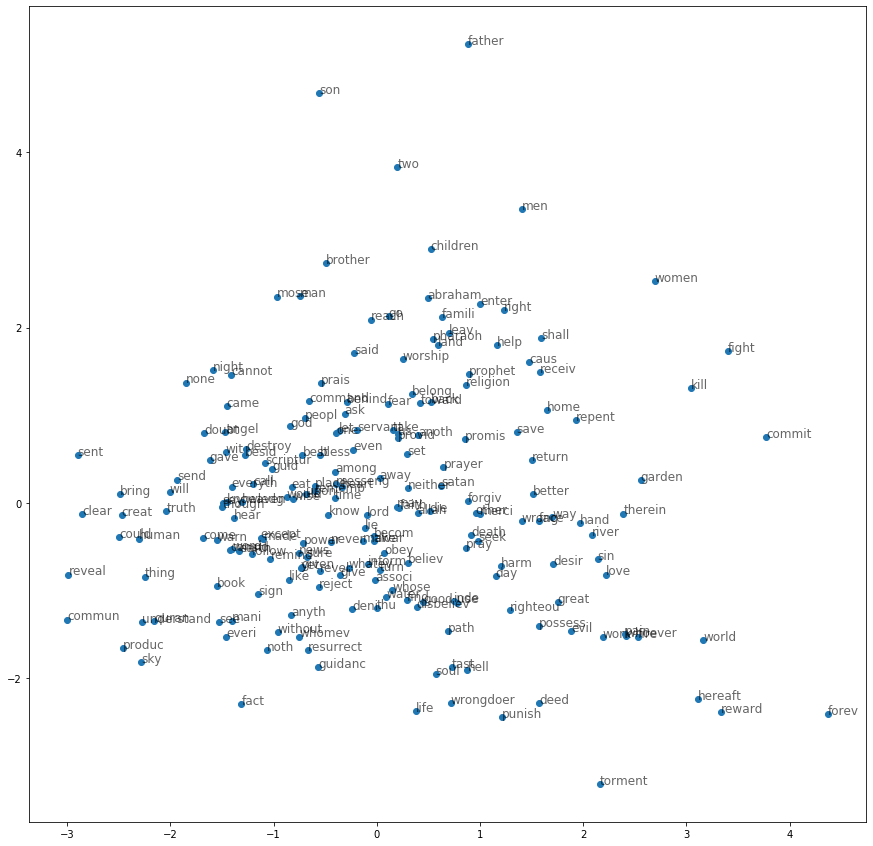

In [187]:
# create a scatter plot of the projection
f, a = plt.subplots(figsize=(15, 15))
a.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    a.annotate(word, xy=(result[i, 0], result[i, 1]), alpha=0.6, fontsize=12)
plt.show()

### modeling

In [ ]:
# LDA modeling
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=5, passes=10)
corpus_lda = lda[corpus] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

a = lda.print_topics(num_topics=-1, num_words=9)

### Results

In [147]:
# Get score for individual verse
i = 1
print docs[i]
print processed[i]
sorted_rel = sorted(corpus_lda[i], key=lambda x: x[1], reverse=True)
print 'Top 3 topics of this doc: \n', sorted_rel[:3]
print 'First topic: \n', a[sorted_rel[0][0]]

this is the book in which there is no doubt, a guide for the righteous.
['book', 'doubt', 'guid', 'right']
Top 3 topics of this doc: 
[(0, 0.57589663577780992), (2, 0.29967287338095344), (1, 0.041814723585403307)]
First topic: 
(0, u'0.019*"peopl" + 0.018*"know" + 0.017*"believ" + 0.016*"ear" + 0.012*"heav" + 0.012*"would" + 0.011*"giv" + 0.011*"everyth" + 0.010*"said"')


(0, u'0.019*"peopl" + 0.018*"know" + 0.017*"believ" + 0.016*"ear" + 0.012*"heav" + 0.012*"would" + 0.011*"giv" + 0.011*"everyth" + 0.010*"said"')
(1, u'0.018*"believ" + 0.015*"know" + 0.013*"said" + 0.012*"god" + 0.011*"messeng" + 0.011*"disbeliev" + 0.011*"among" + 0.009*"fight" + 0.008*"peopl"')
(2, u'0.022*"say" + 0.021*"believ" + 0.016*"us" + 0.012*"day" + 0.012*"giv" + 0.011*"messeng" + 0.009*"wom" + 0.009*"disbeliev" + 0.008*"good"')
(3, u'0.019*"believ" + 0.016*"disbeliev" + 0.014*"mercy" + 0.012*"pun" + 0.011*"toward" + 0.010*"forg" + 0.009*"said" + 0.008*"guid" + 0.008*"may"')
(4, u'0.024*"believ" + 0.016*"forg" + 0.013*"whoev" + 0.012*"peopl" + 0.011*"may" + 0.010*"giv" + 0.009*"messeng" + 0.009*"forev" + 0.009*"gard"')


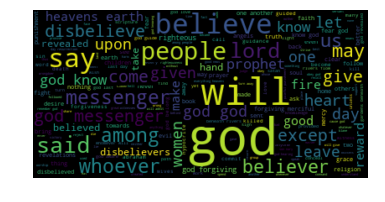

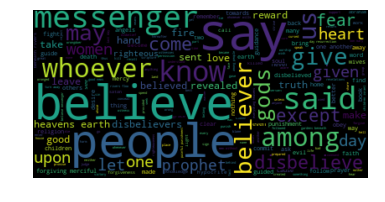

In [145]:
for ii in a:
    print ii
word_cloud(docs)
word_cloud([' '.join(ii) for ii in tokens])

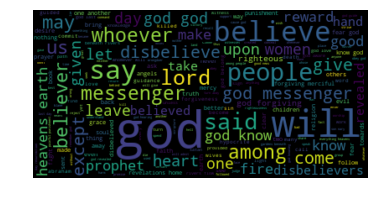

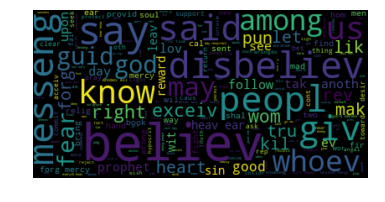

In [88]:
a
word_cloud(docs)
word_cloud([' '.join(ii) for ii in processed])